In [1]:
import os
import netCDF4
import matplotlib.style 
import matplotlib.pyplot as plt
import skimage.graph
import numpy as np
import cmocean.cm
import skimage.draw


%matplotlib inline


In [2]:
model_dir = '/Users/baart_f/models/riomagdelena/DFM_OUTPUT_riomagp_q2600'
N = 2048
min_depth = 2

In [3]:

# read the file
ds = netCDF4.Dataset(os.path.join(model_dir, 'riomagp_q2600_map.nc' ))
# we don't have a crs, todo: cleanup
ds.variables['projected_coordinate_system'][:]

-2147483647

In [4]:
# get waterdepth at t end
depth = ds.variables['waterdepth'][-1]
xc = ds.variables['FlowElemContour_x'][:]
yc = ds.variables['FlowElemContour_y'][:]



In [5]:
# get the bounding box of all cell contours
xmin, xmax = xc.ravel().min(), xc.ravel().max()
ymin, ymax = yc.ravel().min(), yc.ravel().max()
# create equidistant grid of NxN cells
x = np.linspace(xmin, xmax, num=N)
y = np.linspace(ymin, ymax, num=N)
extent = (xmin, xmax, ymin, ymax)

In [6]:
# plot all the cells on the rectilinear grid
img = np.ma.masked_array(np.zeros((N, N)), dtype='float32', mask=True)
for i, (x_, y_) in enumerate(zip(
    N*(xc - xmin)/(xmax - xmin), 
    N*(yc - ymin)/(ymax - ymin)
)):
    rr, cc = skimage.draw.polygon(y_, x_, shape=(N,N))
    img[rr, cc] = depth[i]


In [7]:
# compute some min,max for plotting 
q10 = np.percentile(depth, 10)
q90 = np.percentile(depth, 90)


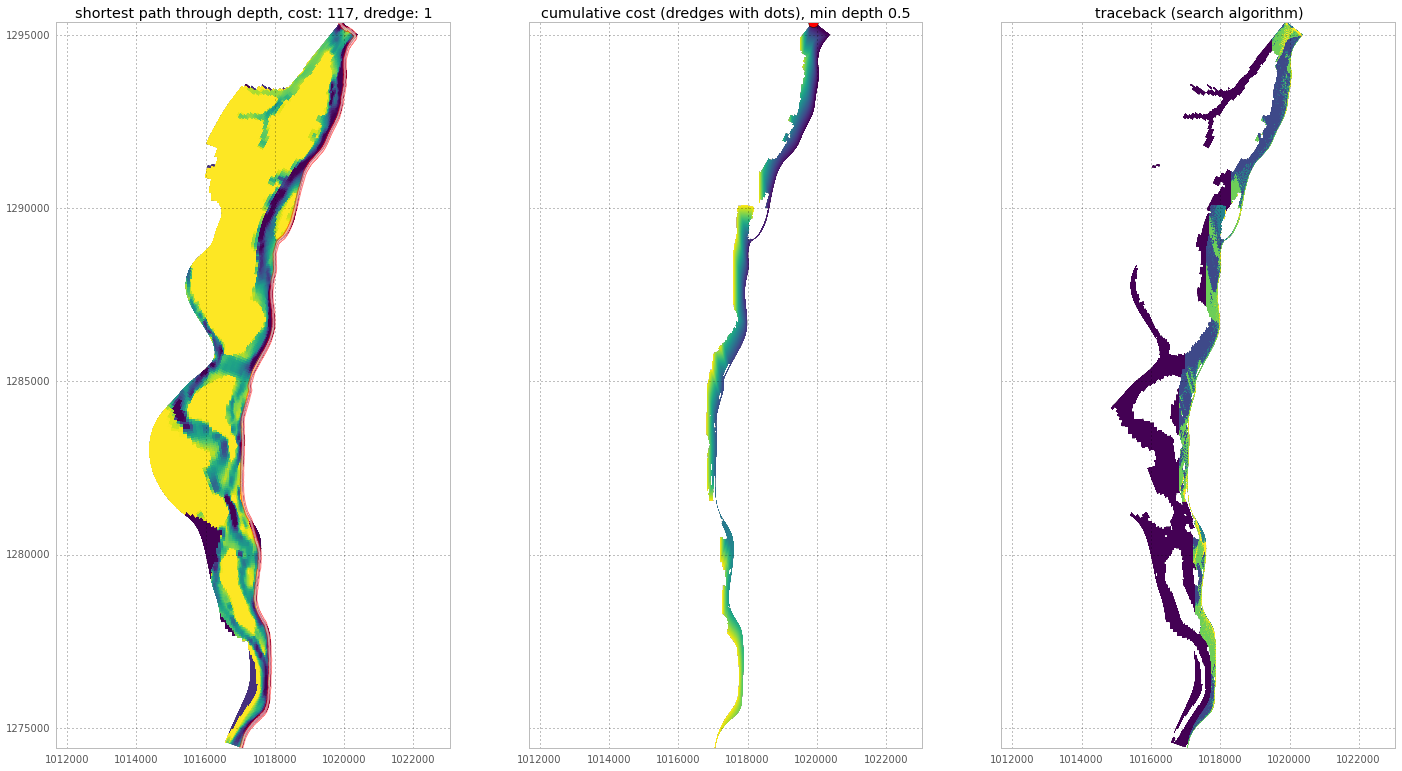

In [39]:
def navigate(img, min_depth):
    """based on a depth image (img), navigate from the top to the bottom, starting and ending in the deepest parts"""

    # find start end end point (start in deepest points in first and last row)
    j0 = img[1,:].argmax()
    end = N - 1
    jn = img[end,:].argmax()

    # mask cells that are not deep enough, non grid cells are also masked
    depth_masked = np.ma.masked_less(img, min_depth)
    
    # generate the cost matrix object
    # we probably want a more advanced cost function, let's do that later, for now, the rule is:
    # - deeper parts cost less
    # - too undeep areas need to be dredged, which costs 1e9 per cell
    # normalized depth_mask
    # deepest area cost 0, undeep areas cost 1.0
    depth_masked_normalized = (depth_masked - depth_masked.min())/(depth_masked.max() - depth_masked.min())
    
    # this is the main navigation object. See skimage.graph manual for details. 
    mcp = skimage.graph.MCP((1 - depth_masked_normalized).filled(1e9))
    
    # generate cost matrices
    cost, traceback = mcp.find_costs(starts=[(0, j0)], ends=[(end,jn)])
    # compute how many cells we have to dredge and the cost function over the path
    dredge, distance = divmod(cost[end, jn], 1e9)
    # traceback from the end
    path = mcp.traceback((end, jn))
    # create a rowcolumn vector
    rowcolumn = np.array(path)
    # lookup path coordinates, not sure why we need to inverse y, guess we have negative pixels??
    xy = np.c_[x[rowcolumn[:,1]], ymax + ymin-y[rowcolumn[:,0]]]
    
    results = dict(
        xy=xy, 
        cost=cost,
        dredge=dredge,
        rowcolumn=rowcolumn,
        traceback=traceback,
        distance=distance,
        depth_masked=depth_masked
    )
    return results

def compute_and_plot(min_depth):
    results = navigate(img, min_depth)
    
    # moved these to a function, just copy them back into current variables
    xy = results['xy']
    cost = results['cost']
    distance = results['distance']
    dredge = results['dredge']
    depth_masked = results['depth_masked']
    rowcolumn = results['rowcolumn']
    traceback = results['traceback']
    
    fig, axes = plt.subplots(1, 3, figsize=(24,13), sharex=True, sharey=True)
    
    axes[0].set_title('shortest path through depth, cost: %.0f, dredge: %d' % (distance, dredge))
    # show deepest areas in blue
    axes[0].imshow(-img, extent=extent, cmap=cmocean.cm.option_d, vmin=-q90, vmax=-q10)
    # negative y pixels
    axes[0].plot(xy[:,0], xy[:,1], 'r-', linewidth=4, alpha=0.5)
    # glow
    axes[0].plot(xy[:,0], xy[:,1], 'w-', linewidth=2, alpha=0.5)
    axes[1].imshow(cost, cmap=cmocean.cm.option_d, extent=extent)
    # plot cells that need to be dredged
    xy_index = np.diff(np.r_[0, cost[rowcolumn[:,0], rowcolumn[:,1]]]) > 1e8
    axes[1].plot(xy[xy_index,0], xy[xy_index,1], 'ro', markersize=10)
    axes[1].set_title('cumulative cost (dredges with dots), min depth %s' % (min_depth))
    axes[2].imshow(np.ma.masked_array(traceback, mask=depth_masked.mask), cmap=cmocean.cm.option_d, extent=extent)
    axes[2].set_title('traceback (search algorithm)')
from IPython.html.widgets import interactive
interactive(compute_and_plot, min_depth=(0.0,20.0, 0.5))

In [16]:
img[1,:].mask.all()

False